<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/ML%E5%9F%BA%E7%A1%80003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install toad

Toad是针对工业届建模而开发的工具包，针对风险评分卡的建模有针对性的功能。


In [2]:
import pandas as pd
import numpy as np
import toad
from sklearn.datasets import load_iris

# 数据载入
iris = load_iris()
target = iris['target']
iris = pd.DataFrame(iris['data'],columns = iris['feature_names'])
iris['target'] = target

# 数据洞察
eda = toad.detect(iris)
qualitys = toad.quality(iris,'target',iv_only=True)

In [3]:
# 分箱
c = toad.transform.Combiner()

# 使用特征筛选后的数据进行训练：使用稳定的卡方分箱，规定每箱至少有5%数据，空值将自动被归到最佳箱
c.fit(iris, y = 'target', method = 'chi', min_samples = 0.05) #empty_separate = False

# 为了演示，仅展示部分分箱
c.export()

{'sepal length (cm)': [5.0, 5.5, 5.8, 6.3, 7.1],
 'sepal width (cm)': [2.5, 2.9, 3.0, 3.1, 3.4, 3.5],
 'petal length (cm)': [3.0, 4.5, 4.6, 4.8, 5.0, 5.2],
 'petal width (cm)': [1.0, 1.4, 1.8, 1.9]}

<Axes: xlabel='sepal length (cm)', ylabel='prop'>

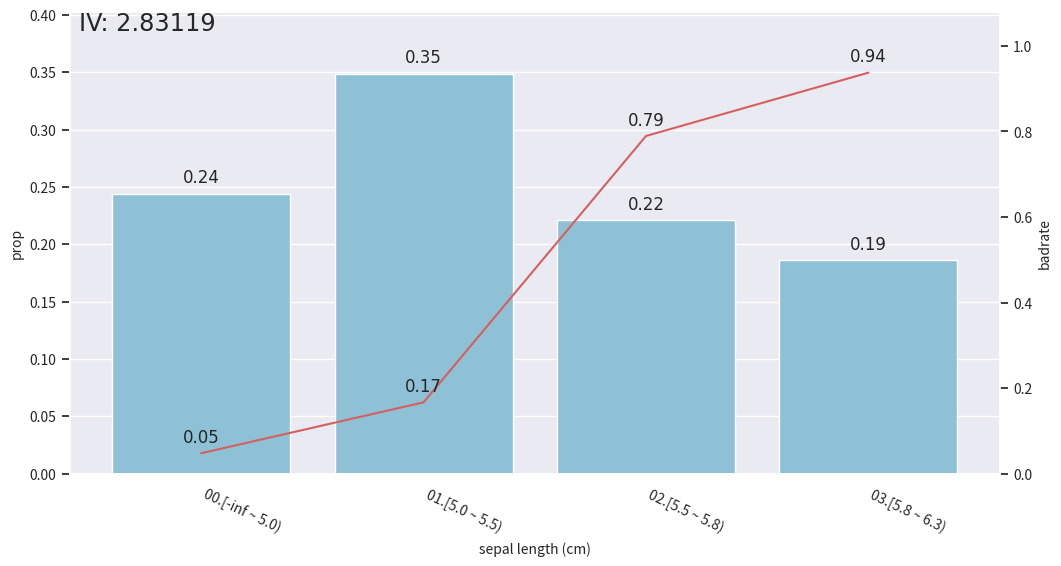

In [4]:
# 画分箱图
from toad.plot import bin_plot

col = 'sepal length (cm)'
bin_plot(c.transform(iris[[col,'target']], labels=True), x=col, target='target')
# 柱子代表了样本量占比，红线代表了正样本占比

In [5]:
# GBDT + LR的树模型特征输出
col = 'sepal length (cm)'
gbdt_transer = toad.transform.GBDTTransformer()
gbdt_transer.fit(iris, 'target', n_estimators = 10, max_depth = 2)
gbdt_vars = gbdt_transer.transform(iris[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']])
iris.shape,gbdt_vars.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


((150, 5), (450, 60))